# The Myers-Briggs Type Indicator (MBTI)

<img src="https://www.careergirldaily.com/wp-content/uploads/2018/10/PERSONALITYTYPES.gif" width="400"/>

The purpose of the [Myers-Briggs Type Indicator® (MBTI®)](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/) personality inventory is to make the theory of psychological types described by C. G. Jung understandable and useful in people's lives. The essence of the theory is that much seemingly random variation in the behavior is actually quite orderly and consistent, being due to basic differences in the ways individuals prefer to use their perception and judgment.

There are [16 personality types](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/the-16-mbti-types.htm) in the Myers-Briggs Type Indicator®, each made up of 4 letters.

<img src= "https://aab54d97d9.cbaul-cdnwnd.com/c804eb73de63c7c2b861567b6ddf858b/200000012-43b5144afd/3kl2hZ0guKiGPhEcTpiX794PB-1R9j3OlOfQtO8N1rE.JPG?ph=aab54d97d9" width="660"/>



## About The Dataset:
This [dataset](https://www.kaggle.com/datasets/datasnaek/mbti-type) contains over 8600 rows of data collected from [PersonalityCafe](http://personalitycafe.com/forum/) forum, on each row is a person’s:
- Type (This person's 4 letter MBTI code/type)
- A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))


## Problem Description
The goal of our project is to classify people's MBTI personality types based on  their comments.

#### Imports

In [4]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

Use this simple hack for Auto-Click to avoid being kicked off Colab VM
Press (Ctrl + Shift + i) . Go to console. Paste the following code and press Enter.
```
function ClickConnect(){
console.log("Working");
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click()
}
setInterval(ClickConnect,60000)
```


#### Preprocessing

###### 1. Read the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('drive/MyDrive/mbti_1.csv')
df["posts"] # There are URLs that need to be removed

0       'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1       'I'm finding the lack of me in these posts ver...
2       'Good one  _____   https://www.youtube.com/wat...
3       'Dear INTP,   I enjoyed our conversation the o...
4       'You're fired.|||That's another silly misconce...
                              ...                        
8670    'https://www.youtube.com/watch?v=t8edHB_h908||...
8671    'So...if this thread already exists someplace ...
8672    'So many questions when i do these things.  I ...
8673    'I am very conflicted right now when it comes ...
8674    'It has been too long since I have been on per...
Name: posts, Length: 8675, dtype: object

###### 2. Clean the data

In [6]:
def clean(txt):
  posts = txt.split("|||") # split so that each post is seperated
  for i in range(len(posts)):
    posts[i] = re.sub(r"http\S+", "(URL)", posts[i]) # replace the link with the word URL

  return posts

# clean the posts and separate them
# then remove any leftover empty strings
df["posts_cleaned"] = df["posts"].apply(clean).apply(lambda x: list(filter(None, x)))
df["posts_cleaned"]

0       ['(URL), (URL), enfp and intj moments  (URL)  ...
1       ['I'm finding the lack of me in these posts ve...
2       ['Good one  _____   (URL), Of course, to which...
3       ['Dear INTP,   I enjoyed our conversation the ...
4       ['You're fired., That's another silly misconce...
                              ...                        
8670    ['(URL), IxFP just because I always think of c...
8671    ['So...if this thread already exists someplace...
8672    ['So many questions when i do these things.  I...
8673    ['I am very conflicted right now when it comes...
8674    ['It has been too long since I have been on pe...
Name: posts_cleaned, Length: 8675, dtype: object

#### Visualization

###### 1. WordCloud
What are the most used words in each class?

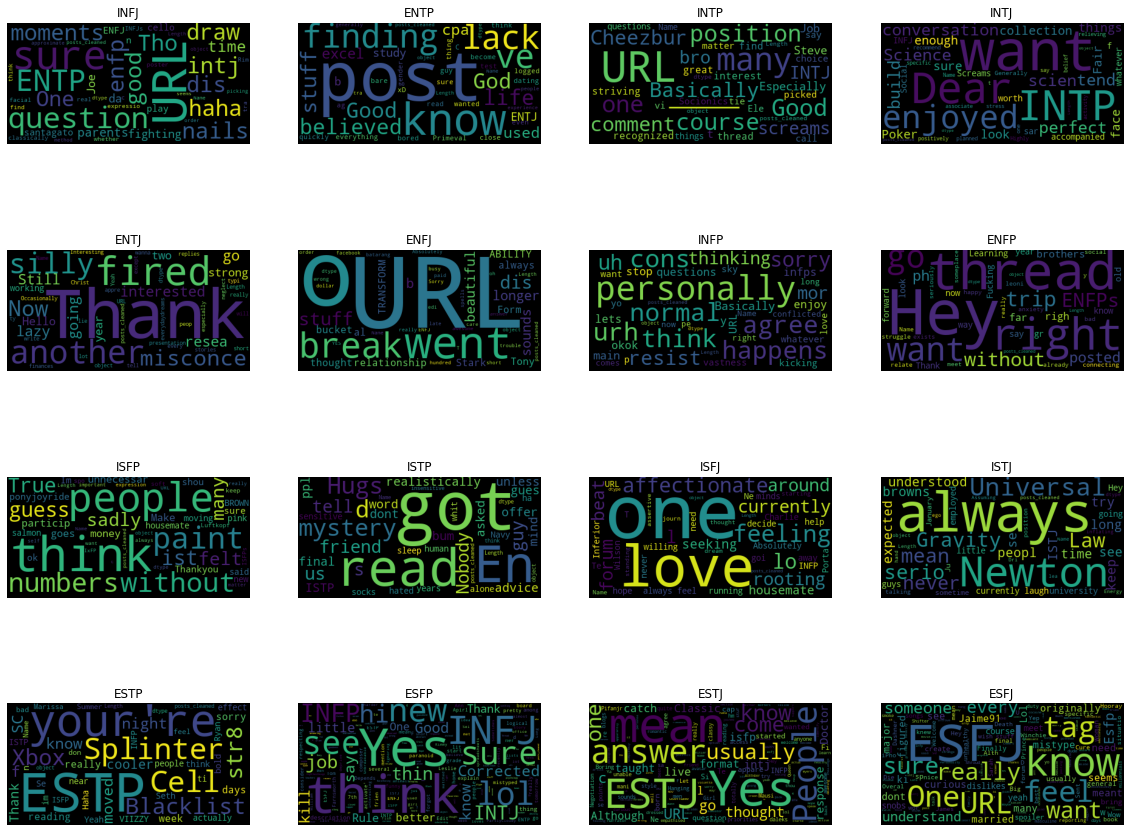

In [7]:
types = df["type"].unique() # 16 types

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, figsize=(20, len(types)))

t = 0
for i in range(4):
  for j in range(4):
    wc = WordCloud().generate(str(df[df["type"] == types[t]]["posts_cleaned"]))
    ax[i, j].imshow(wc)
    ax[i, j].set_title(types[t])
    ax[i, j].axis("off")
    t+=1

###### 2. Barplot
The class with the most instances is INFP. Meanwhile, the class with the least instances is ESTJ. 

This dataset is [imbalanced](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb)!

***What should we do?***

- First, we should **NOT** use accuracy as an evaluation metric, ***why?***

  Because class imbalance leads to a heavy bias/skew towards larger classes and classes with fewer data points are treated as **noise** and are often **ignored**. The result is a higher misclassification rate for minority classes compared to the majority classes. Therefore, the accuracy metric is not as relevant when evaluating the performance of a model trained on imbalanced data.

- We can use Oversampling — This is the process of replicating the minority class instances randomly. This approach may lead to overfitting.
- We can also use Undersampling — This is the process of eliminating data points from the majority class randomly until the classes are balanced. There is a likelihood of information loss which might lead to poor model training  if the data is not big enough.
- Data augmentation - Mostly used in Computer Vision, in the case of textual data, the is not enough documentation.

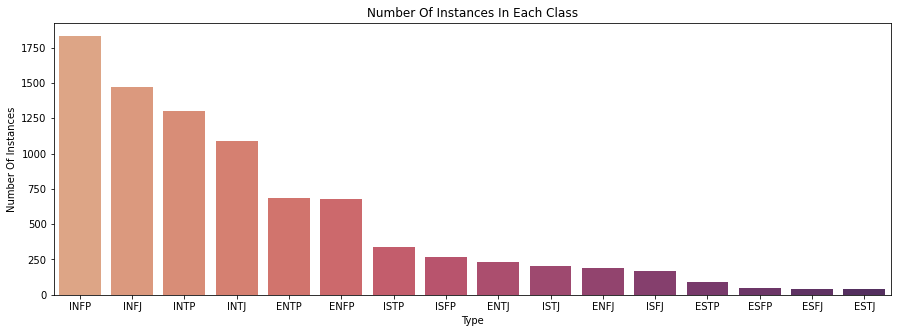

In [8]:
num_in_types = df["type"].value_counts()

plt.figure(figsize=(15, 5))
sns.barplot(x=num_in_types.index, y=num_in_types.values, 
            palette="flare").set(title="Number Of Instances In Each Class",
                                 xlabel="Type", ylabel="Number Of Instances");

###### 3. Number of Words/Post
We got that the most range number for words per post is approximately about 30 words.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


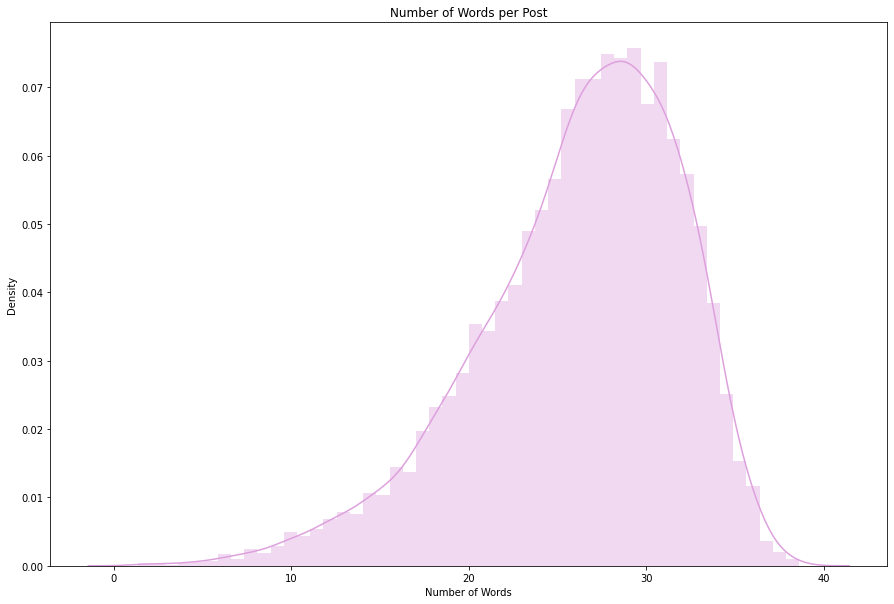

In [9]:
def count_words_per_post(posts):
  count = 0
  for post in posts:
    count += len(post.split())
  
  return count/len(posts)

num_words = df["posts_cleaned"].apply(count_words_per_post)

plt.figure(figsize=(15,10))
sns.distplot(num_words, color="plum").set(title="Number of Words per Post", 
                                       xlabel="Number of Words");

###### 4. Number of Words/Post For Each Type
From the chart we noticed that INFJ type has the highest words per post. However, there is a class imbalance in the data and that is why there might be a bias.

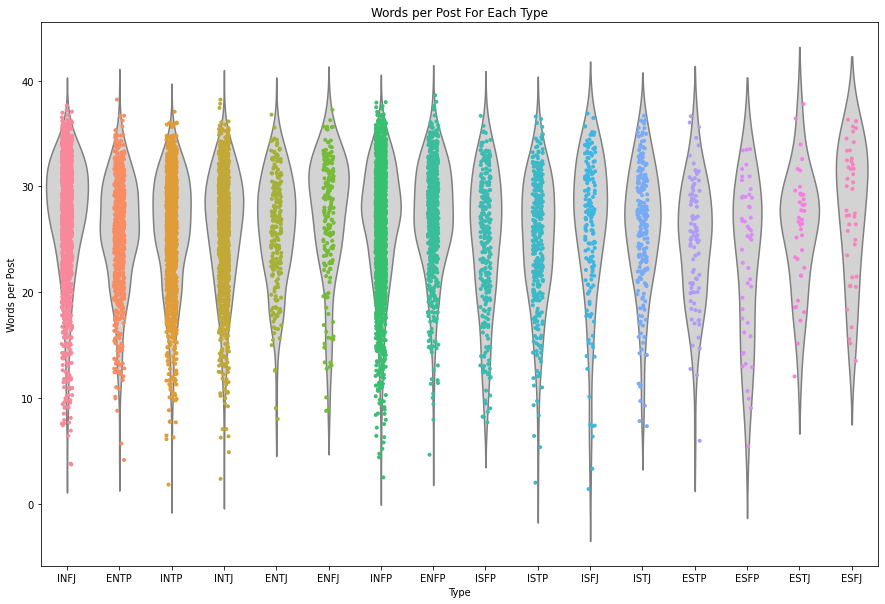

In [10]:
plt.figure(figsize=(15, 10))
sns.violinplot(x="type", y=num_words , data=df, inner=None, color="lightgray")
sns.stripplot(x="type", y= num_words , data=df, size=4, 
              jitter=True).set(title="Words per Post For Each Type", 
                               ylabel="Words per Post", xlabel="Type");

###### 5. Variance of Words

In [11]:
def var_row(row):
    l = []
    for i in row:
        l.append(len(i.split()))
    return np.var(l)

df["variance_of_word_counts"] = df["posts_cleaned"].apply(lambda x: var_row(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x1440 with 0 Axes>

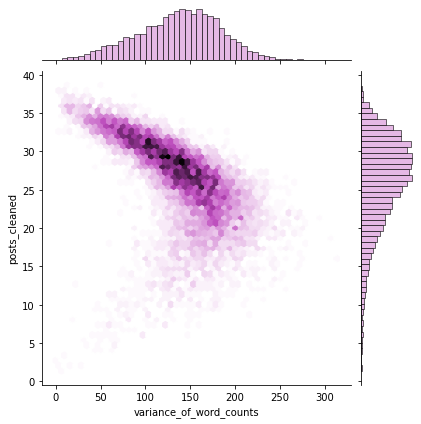

In [12]:
plt.figure(figsize=(15,20))
sns.jointplot("variance_of_word_counts", num_words, data=df, 
              kind="hex", color="plum");

## Training The Models

#### Solving Class Imbalance:
To solve the class imbalance problem we will be using [Synthetic Minority Oversampling (**SMOTE**) Technique](https://www.dominodatalab.com/blog/smote-oversampling-technique).

![img.png](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F1104%2F1*3pI3d_3ec0fHk1VKN840ww.png&f=1&nofb=1)

We used SMOTE because regular oversampling creates many duplicate data points which may lead to overfitting.
SMOTE is an algorithm that performs **data augmentation** by creating synthetic data points based on the original data points. SMOTE can be seen as an **advanced version of oversampling**, or as a specific algorithm for data augmentation. The advantage of SMOTE is that you are not generating duplicates, but rather creating **synthetic data points that are slightly different from the original data points.**

 We will compare the results with and without SMOTE oversampling.

#### Feature Extraction:
We used [**CountVectorizer**](https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp).

Before we use text for modeling we need to process it. The steps include **removing stop words**, **lemmatizing**, **stemming**, **tokenization**, and **vectorization**. 

The stop words are words that are not significant and occur frequently. For example the, and, is, in, etc. 

Stemmer and lemmatizer are used to preprocess the text which we did earlier.

Tokenization means breaking down a sentence or paragraph or any text into words.

Vectorization is a process of converting the text data into a machine-readable form. The words are represented as vectors.

In [13]:
X = np.transpose(np.stack(df['posts_cleaned'].apply(lambda x: " ".join(x))))
y = np.transpose(np.stack(df["type"])) # transform it into 2D array 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, stratify=y)

#### Scoring:

`neg_log_loss`:

[**Log loss**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss), aka logistic loss or cross-entropy loss.

Log Loss is the most important classification metric based on probabilities.

It's hard to interpret raw log-loss values, but log-loss is still a good metric for comparing models. For any given problem, a lower log-loss value means better predictions.
 
`neg_log_loss` is basically -log loss.

In [14]:
grid_score = "neg_log_loss"

#### 1. Multinomial Naïve Bayes

In [15]:
mnb_param=[{"mnb__alpha":[0.01, 0.1, 1, 10, 100]}]

###### Without SMOTE Oversampling

In [16]:
mnb_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("mnb", MultinomialNB())
])
grid_mnb = GridSearchCV(estimator=mnb_pipeline, param_grid=mnb_param, 
                        scoring=grid_score, cv=3)

In [ ]:
grid_mnb.fit(X_train, y_train) # train

In [18]:
y_hat = grid_mnb.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))
print(f"\nBest -log loss score is:\n{grid_mnb.best_score_}")

              precision    recall  f1-score   support

        ENFJ       0.68      0.39      0.50        38
        ENFP       0.47      0.56      0.51       135
        ENTJ       0.46      0.41      0.44        46
        ENTP       0.44      0.51      0.47       137
        ESFJ       1.00      0.11      0.20         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.38      0.17      0.23        18
        INFJ       0.66      0.52      0.59       294
        INFP       0.61      0.74      0.67       366
        INTJ       0.63      0.56      0.60       218
        INTP       0.65      0.70      0.68       261
        ISFJ       0.48      0.39      0.43        33
        ISFP       0.24      0.28      0.26        54
        ISTJ       0.61      0.41      0.49        41
        ISTP       0.49      0.54      0.51        67

    accuracy                           0.57      1735
   macro avg       0.49   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


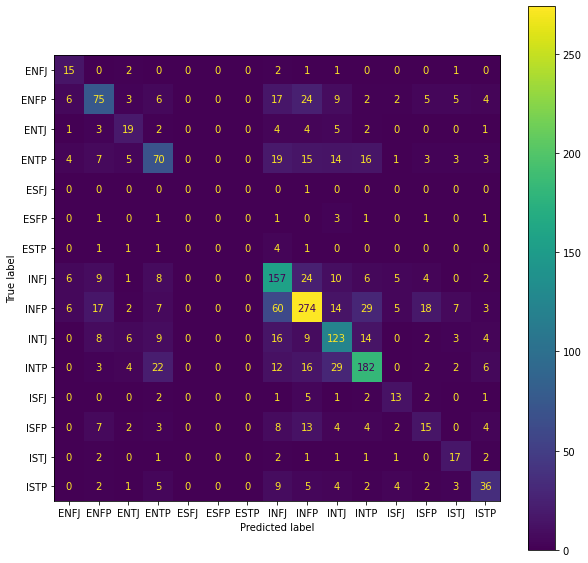

In [19]:
_, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_mnb.best_estimator_, y_test, y_hat, ax=ax);

In [107]:
print(f"Predicted: {grid_mnb.best_estimator_.predict([X_test[1654]])[0]},",
      f"True: {y_test[1654]}") # from testset

Predicted: ESTP, True: ESTP


In [20]:
print(grid_mnb.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

INFP


###### With SMOTE Oversampling

In [21]:
mnb_smote_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("smote", SMOTE(random_state=12)),
  ("mnb", MultinomialNB())
])

grid_mnb_smote = GridSearchCV(estimator=mnb_smote_pipeline, param_grid=mnb_param, 
                              scoring=grid_score, cv=3)

In [ ]:
grid_mnb_smote.fit(X_train, y_train) # train

In [23]:
y_hat = grid_mnb_smote.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))
print(f"\nBest -log loss score is:\n{grid_mnb_smote.best_score_}")

              precision    recall  f1-score   support

        ENFJ       0.50      0.13      0.21        38
        ENFP       0.46      0.47      0.47       135
        ENTJ       0.43      0.13      0.20        46
        ENTP       0.41      0.44      0.42       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.60      0.58      0.59       294
        INFP       0.55      0.73      0.63       366
        INTJ       0.59      0.61      0.60       218
        INTP       0.59      0.74      0.66       261
        ISFJ       0.44      0.12      0.19        33
        ISFP       0.30      0.19      0.23        54
        ISTJ       0.71      0.12      0.21        41
        ISTP       0.49      0.33      0.39        67

    accuracy                           0.54      1735
   macro avg       0.38   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


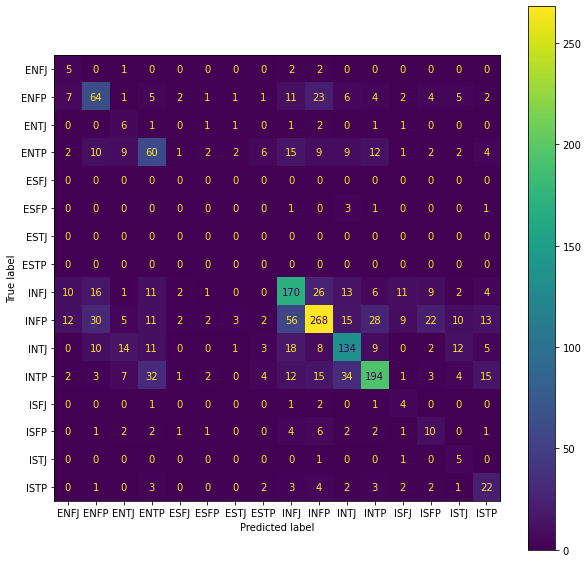

In [24]:
_, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_mnb_smote.best_estimator_, y_test, y_hat, ax=ax);

In [112]:
print(f"Predicted: {grid_mnb_smote.best_estimator_.predict([X_test[1654]])[0]},",
      f"True: {y_test[1654]}") # from testset

Predicted: INTJ, True: ESTP


In [25]:
print(grid_mnb_smote.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

ISFP


#### 2. Logistic Regression
Penalty (aka regularization) help in shrinking the coefficients of the less contributive variables.

In [26]:
lr_param = [{"lr__penalty": ["l2", "none"],
             "lr__solver": ["newton-cg", "lbfgs"],
             "lr__C": [0.5, 1, 1.5]}]

###### Without SMOTE Oversampling

In [27]:
lr_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("lr", LogisticRegression(random_state=0, max_iter=5000))
])
grid_lr = GridSearchCV(estimator=lr_pipeline, param_grid=lr_param, 
                        scoring=grid_score, cv=3)

In [ ]:
grid_lr.fit(X_train, y_train) # train

In [29]:
y_hat = grid_lr.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))
print(f"\nBest -log loss score is:\n{grid_lr.best_score_}")

              precision    recall  f1-score   support

        ENFJ       0.73      0.42      0.53        38
        ENFP       0.62      0.61      0.61       135
        ENTJ       0.58      0.41      0.48        46
        ENTP       0.64      0.55      0.59       137
        ESFJ       1.00      0.22      0.36         9
        ESFP       0.50      0.10      0.17        10
        ESTJ       1.00      0.25      0.40         8
        ESTP       0.83      0.28      0.42        18
        INFJ       0.63      0.67      0.65       294
        INFP       0.67      0.77      0.72       366
        INTJ       0.61      0.69      0.65       218
        INTP       0.63      0.70      0.67       261
        ISFJ       0.59      0.39      0.47        33
        ISFP       0.43      0.33      0.38        54
        ISTJ       0.71      0.49      0.58        41
        ISTP       0.62      0.52      0.57        67

    accuracy                           0.64      1735
   macro avg       0.67   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


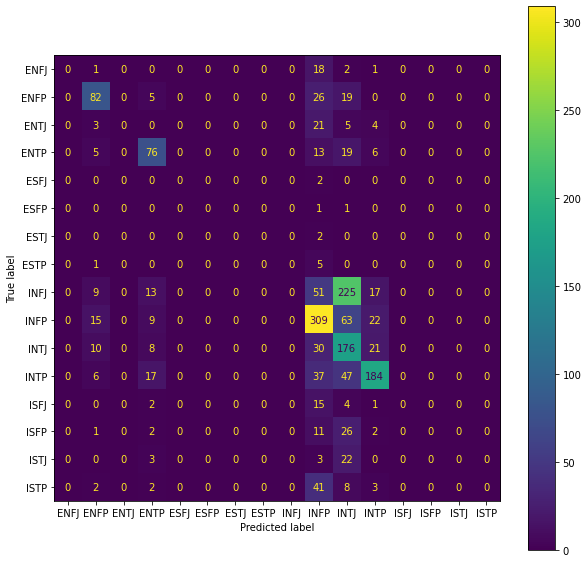

In [30]:
_, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_lr.best_estimator_, y_test, y_hat, ax=ax);

In [114]:
print(f"Predicted: {grid_lr.best_estimator_.predict([X_test[1654]])[0]},",
      f"True: {y_test[1654]}") # from testset

Predicted: ESTP, True: ESTP


In [31]:
print(grid_lr.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

INFP


###### With SMOTE Oversampling

In [32]:
lr_smote_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("smote", SMOTE(random_state=12)),
  ("lr", LogisticRegression(random_state=0, max_iter=5000))
])
grid_lr_smote = GridSearchCV(estimator=lr_smote_pipeline, param_grid=lr_param, 
                        scoring=grid_score, cv=3)

In [ ]:
grid_lr_smote.fit(X_train, y_train) # train

In [38]:
y_hat = grid_lr_smote.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))
print(f"\nBest -log loss score is:\n{grid_lr_smote.best_score_}")

              precision    recall  f1-score   support

        ENFJ       0.65      0.39      0.49        38
        ENFP       0.57      0.53      0.55       135
        ENTJ       0.57      0.52      0.55        46
        ENTP       0.58      0.55      0.56       137
        ESFJ       0.33      0.22      0.27         9
        ESFP       0.25      0.10      0.14        10
        ESTJ       0.67      0.25      0.36         8
        ESTP       0.55      0.33      0.41        18
        INFJ       0.62      0.65      0.63       294
        INFP       0.66      0.72      0.69       366
        INTJ       0.61      0.65      0.63       218
        INTP       0.62      0.66      0.64       261
        ISFJ       0.47      0.42      0.44        33
        ISFP       0.41      0.37      0.39        54
        ISTJ       0.53      0.39      0.45        41
        ISTP       0.54      0.54      0.54        67

    accuracy                           0.61      1735
   macro avg       0.54   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


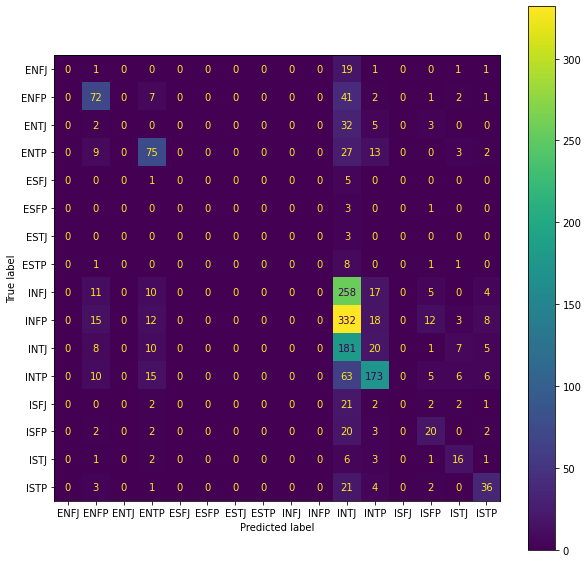

In [39]:
_, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_lr_smote.best_estimator_, y_test, y_hat, ax=ax);

In [116]:
print(f"Predicted: {grid_lr_smote.best_estimator_.predict([X_test[1654]])[0]},",
      f"True: {y_test[1654]}") # from testset

Predicted: ESTP, True: ESTP


In [37]:
print(grid_lr_smote.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

INTJ


#### 3. Random Forest Classifier
Criterion (`gini`, `entropy`) is the function used to measure the quality of a split

In [40]:
rf_param = [{"rf__criterion": ["gini", "entropy"],
             "rf__n_estimators": [10, 50, 100],
             "rf__max_depth": [8, 10, 12]}]

###### Without SMOTE Oversampling

In [91]:
rf_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("rf", RandomForestClassifier(random_state=0))
])
grid_rf = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param, 
                        scoring=grid_score, cv=3)

In [ ]:
grid_rf.fit(X_train, y_train) # train

In [93]:
y_hat = grid_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))
print(f"\nBest -log loss score is:\n{grid_rf.best_score_}")

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.82      0.10      0.18       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.73      0.28      0.40       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.57      0.59      0.58       294
        INFP       0.36      0.94      0.52       366
        INTJ       0.69      0.47      0.56       218
        INTP       0.63      0.61      0.62       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       1.00      0.06      0.11        67

    accuracy                           0.48      1735
   macro avg       0.30   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


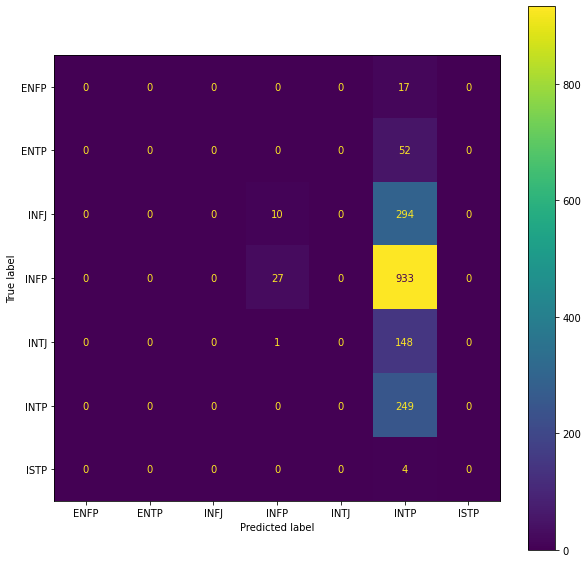

In [94]:
_, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_rf.best_estimator_, y_test, y_hat, ax=ax);

In [117]:
print(f"Predicted: {grid_rf.best_estimator_.predict([X_test[1654]])[0]},",
      f"True: {y_test[1654]}") # from testset

Predicted: INFP, True: ESTP


In [46]:
print(grid_rf.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

INFP


###### With SMOTE Oversampling

In [77]:
rf_smote_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("smote", SMOTE(random_state=12)),
  ("rf", RandomForestClassifier(random_state=0))
])
grid_rf_smote = GridSearchCV(estimator=rf_smote_pipeline, param_grid=rf_param, 
                        scoring=grid_score, cv=3)

In [ ]:
grid_rf_smote.fit(X_train, y_train) # train

In [79]:
y_hat = grid_rf_smote.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))
print(f"\nBest -log loss score is:\n{grid_rf_smote.best_score_}")

              precision    recall  f1-score   support

        ENFJ       0.47      0.42      0.44        38
        ENFP       0.60      0.45      0.52       135
        ENTJ       0.64      0.39      0.49        46
        ENTP       0.60      0.65      0.62       137
        ESFJ       0.50      0.22      0.31         9
        ESFP       0.17      0.10      0.12        10
        ESTJ       0.25      0.25      0.25         8
        ESTP       0.36      0.28      0.31        18
        INFJ       0.56      0.57      0.57       294
        INFP       0.55      0.79      0.65       366
        INTJ       0.72      0.50      0.59       218
        INTP       0.69      0.59      0.63       261
        ISFJ       0.38      0.30      0.34        33
        ISFP       0.38      0.48      0.43        54
        ISTJ       0.44      0.37      0.40        41
        ISTP       0.55      0.51      0.53        67

    accuracy                           0.57      1735
   macro avg       0.49   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


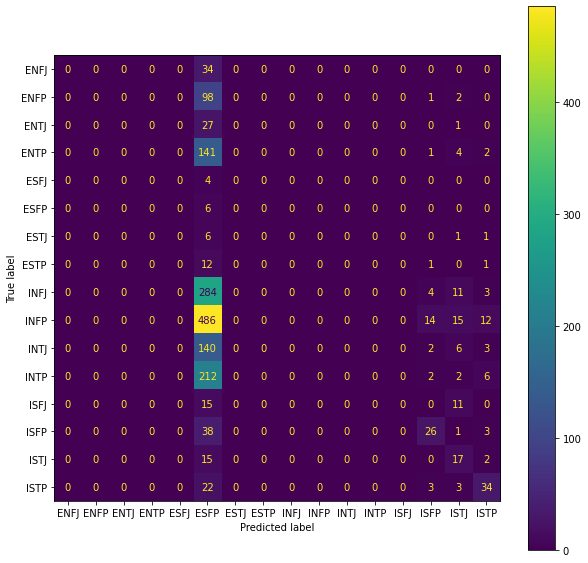

In [80]:
_, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_rf_smote.best_estimator_, y_test, y_hat, ax=ax);

In [118]:
print(f"Predicted: {grid_rf_smote.best_estimator_.predict([X_test[1654]])[0]},",
      f"True: {y_test[1654]}") # from testset

Predicted: ESTP, True: ESTP


In [119]:
print(grid_rf_smote.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

ISTJ


## Results and Conclusion

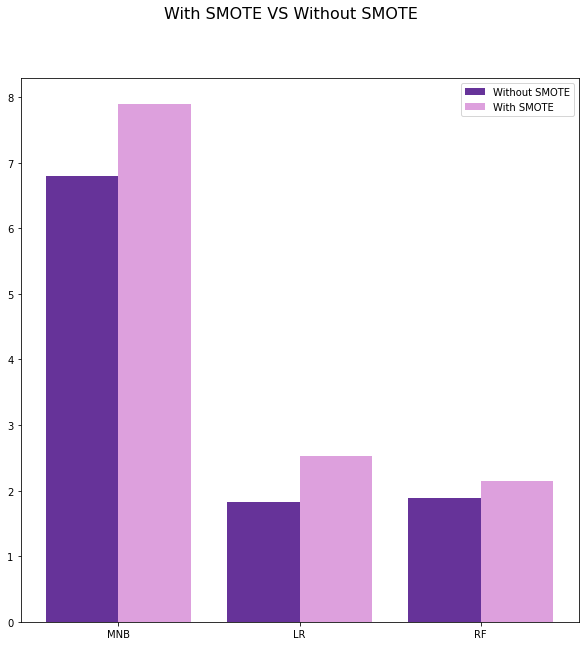

In [135]:
plt.figure(figsize=(10, 10))
plt.suptitle("With SMOTE VS Without SMOTE", fontsize=16)

without_smote = np.array([-grid_mnb.best_score_, 
                          -grid_lr.best_score_, 
                          -grid_rf.best_score_])

with_smote = np.array([-grid_mnb_smote.best_score_, 
                       -grid_lr_smote.best_score_, 
                       -grid_rf_smote.best_score_])

names = np.array(["MNB", "LR", "RF"])
x_axis = np.arange(len(names))

plt.bar(x_axis-0.2, without_smote, width=0.4, label="Without SMOTE", 
        color="rebeccapurple")
plt.bar(x_axis+0.2, with_smote, width=0.4, label="With SMOTE", 
        color="plum")

plt.xticks(x_axis, names)
plt.legend();